In [1]:
# При изменениях в коде проекте эти обновления будут автоматически подгружаться в ноутбук
%load_ext autoreload
%autoreload 2

In [ ]:
import os
import sys
import inspect
import argparse
import numpy as np
from detox import DeToxEdit
import torch

currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, parentdir)

from utils.startup import main
from evaluation.evaluate_model import evaluate_model

if '__file__' in globals():
    parser = argparse.ArgumentParser(description='DeTox')
    parser.add_argument('--config_file', default='gpt2-medium.ini', type=str, help='Config Filename. E.g. gpt2-medium.ini')
    args = parser.parse_args()
    config_filename = args.config_file
else:
    config_filename = 'gpt2-medium.ini'

config = main(config_filename=config_filename)


/Users/ellina/Documents/Projection Filter for Subspaces/detox-edit/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/ellina/Documents/Projection Filter for Subspaces/detox-edit/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
from utils.model_utils import load_large_model
from detox import DeToxEdit

model_id = 'gpt2'
model, tokenizer = load_large_model(model_id)

INFO:root:Model gpt2 loaded.


In [ ]:
lower_layer = 10
upper_layer = 24

layer_range = np.arange(lower_layer, upper_layer) if lower_layer != -1 and upper_layer != -1 else None

In [ ]:
import json
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import logging

In [ ]:
data_paths = {
    #"toxicity": "toxicity_pairwise/toxicity.jsonl",
    #"sentiment": "toxicity_pairwise/sentiment.jsonl",
    "clickbait": "toxicity_pairwise/clickbait.jsonl"
}

results_clickbait = {}

for domain, path in data_paths.items():
    print(f"Обрабатываем домен: {domain}")
    
    editor_no_center = editor = DeToxEdit(
    model=model,
    tokenizer=tokenizer,
    pref_data_dps=313,
    centering=False,
    top_k_ranks=2,
    edit_layer_range=layer_range,
    random_dps=True
)
    not_center_ats, not_center_pref_matrix = editor_no_center.get_ats(path)
    
    editor_center = DeToxEdit(
    model=model,
    tokenizer=tokenizer,
    pref_data_dps=313,
    centering=True,
    top_k_ranks=2,
    edit_layer_range=layer_range,
    random_dps=True
)
    center_ats, center_pref_matrix = editor_center.get_ats(path)
    
    results_clickbait[domain] = {
        "not_center_ats": not_center_ats,
        "not_center_pref_matrix": not_center_pref_matrix,
        "center_ats": center_ats,
        "center_pref_matrix": center_pref_matrix
    }

In [ ]:
data_paths = {
    "toxicity": "toxicity_pairwise/toxicity.jsonl",
    #"sentiment": "toxicity_pairwise/sentiment.jsonl",
    #"clickbait": "toxicity_pairwise/clickbait.jsonl"
}

results_toxicity = {}

for domain, path in data_paths.items():
    print(f"Обрабатываем домен: {domain}")
    
    editor_no_center = editor = DeToxEdit(
    model=model,
    tokenizer=tokenizer,
    pref_data_dps=313,
    centering=False,
    top_k_ranks=2,
    edit_layer_range=layer_range,
    random_dps=True
)
    not_center_ats, not_center_pref_matrix = editor_no_center.get_ats(path)
    

    
    results_toxicity = {
        "not_center_ats": not_center_ats,
        "not_center_pref_matrix": not_center_pref_matrix,
    }

Обрабатываем домен: toxicity


INFO:root:Loaded 313 preferred and 313 non-preferred samples.
INFO:root:Batch 1/6 of size 50
INFO:root:Batch 2/6 of size 50
INFO:root:Batch 3/6 of size 50
INFO:root:Batch 4/6 of size 50
INFO:root:Batch 5/6 of size 50
INFO:root:Batch 6/6 of size 50
INFO:root:Hidden sent: torch.Size([24, 300, 1024])
INFO:root:Batch 1/6 of size 50
INFO:root:Batch 2/6 of size 50
INFO:root:Batch 3/6 of size 50
INFO:root:Batch 4/6 of size 50
INFO:root:Batch 5/6 of size 50
INFO:root:Batch 6/6 of size 50
INFO:root:Hidden sent: torch.Size([24, 300, 1024])
INFO:root:Preference matrix calculated.
INFO:root:Loaded 313 preferred and 313 non-preferred samples.
INFO:root:Batch 1/6 of size 50
INFO:root:Batch 2/6 of size 50
INFO:root:Batch 3/6 of size 50
INFO:root:Batch 4/6 of size 50
INFO:root:Batch 5/6 of size 50
INFO:root:Batch 6/6 of size 50
INFO:root:Hidden sent: torch.Size([24, 300, 1024])
INFO:root:Batch 1/6 of size 50
INFO:root:Batch 2/6 of size 50
INFO:root:Batch 3/6 of size 50
INFO:root:Batch 4/6 of size 50
I

In [ ]:
def pca_visualize_pref_matrices(pref_matrix_1, pref_matrix_2, title, labels=("Без центрирования", "С центрированием")):
    """
    Применяет PCA к двум матрицам предпочтений и строит один график.
    Args:
        pref_matrix_1 (torch.Tensor): Первая матрица предпочтений (L, N, D).
        pref_matrix_2 (torch.Tensor): Вторая матрица предпочтений (L, N, D).
        title (str): Заголовок графика.
        labels (tuple): Метки для легенды.
    """
    from sklearn.decomposition import PCA
    
    all_layers_1 = pref_matrix_1.cpu().numpy().reshape(-1, pref_matrix_1.shape[-1])  # (L*N, D)
    all_layers_2 = pref_matrix_2.cpu().numpy().reshape(-1, pref_matrix_2.shape[-1])  # (L*N, D)
    
    combined_layers = np.vstack((all_layers_1, all_layers_2))
    
    pca = PCA(n_components=2)
    reduced = pca.fit_transform(combined_layers)
    
    reduced_1 = reduced[:len(all_layers_1)]
    reduced_2 = reduced[len(all_layers_1):]
    
    plt.figure(figsize=(8, 6))
    plt.scatter(reduced_1[:, 0], reduced_1[:, 1], s=2, alpha=0.5, label=labels[0], color="blue")
    plt.scatter(reduced_2[:, 0], reduced_2[:, 1], s=2, alpha=0.5, label=labels[1], color="orange")
    plt.title(title)
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.legend()
    plt.show()


In [ ]:
data_paths = {
    #"toxicity": "toxicity_pairwise/toxicity.jsonl",
    "sentiment": "toxicity_pairwise/sentiment.jsonl",
    #"clickbait": "toxicity_pairwise/clickbait.jsonl"
}


results_sentiment = {}

for domain, path in data_paths.items():
    print(f"Обрабатываем домен: {domain}")
    
    editor_no_center = editor = DeToxEdit(
    model=model,
    tokenizer=tokenizer,
    pref_data_dps=313,
    centering=False,
    top_k_ranks=2,
    edit_layer_range=layer_range,
    random_dps=True
)
    not_center_ats, not_center_pref_matrix = editor_no_center.get_ats(path)
    
    results_sentiment = {
        "not_center_ats": not_center_ats,
        "not_center_pref_matrix": not_center_pref_matrix,
    }

INFO:root:Loaded 313 preferred and 313 non-preferred samples.
INFO:root:Batch 1/6 of size 50


Обрабатываем домен: sentiment


INFO:root:Batch 2/6 of size 50
INFO:root:Batch 3/6 of size 50
INFO:root:Batch 4/6 of size 50
INFO:root:Batch 5/6 of size 50
INFO:root:Batch 6/6 of size 50
INFO:root:Hidden sent: torch.Size([24, 300, 1024])
INFO:root:Batch 1/6 of size 50
INFO:root:Batch 2/6 of size 50
INFO:root:Batch 3/6 of size 50
INFO:root:Batch 4/6 of size 50
INFO:root:Batch 5/6 of size 50
INFO:root:Batch 6/6 of size 50
INFO:root:Hidden sent: torch.Size([24, 300, 1024])
INFO:root:Preference matrix calculated.
INFO:root:Loaded 313 preferred and 313 non-preferred samples.
INFO:root:Batch 1/6 of size 50
INFO:root:Batch 2/6 of size 50
INFO:root:Batch 3/6 of size 50
INFO:root:Batch 4/6 of size 50
INFO:root:Batch 5/6 of size 50
INFO:root:Batch 6/6 of size 50
INFO:root:Hidden sent: torch.Size([24, 300, 1024])
INFO:root:Batch 1/6 of size 50
INFO:root:Batch 2/6 of size 50
INFO:root:Batch 3/6 of size 50
INFO:root:Batch 4/6 of size 50
INFO:root:Batch 5/6 of size 50
INFO:root:Batch 6/6 of size 50
INFO:root:Hidden sent: torch.Siz

Визуализация для домена: toxicity
Сравнение для поддомена: toxicity


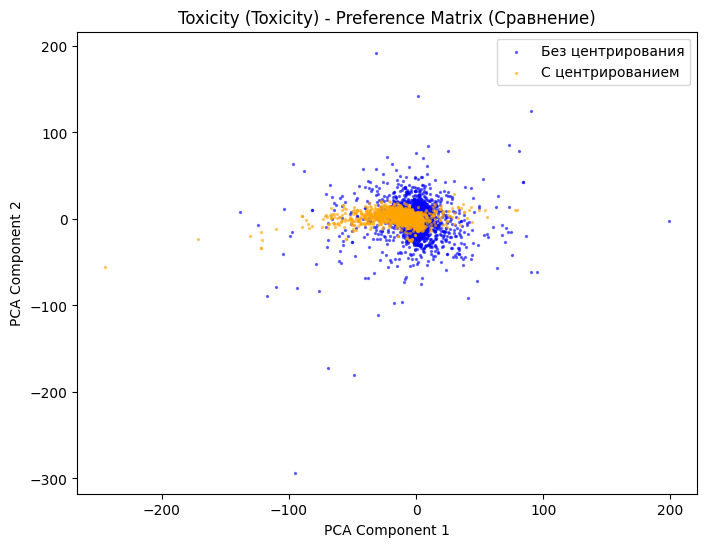

Визуализация для домена: clickbait
Сравнение для поддомена: clickbait


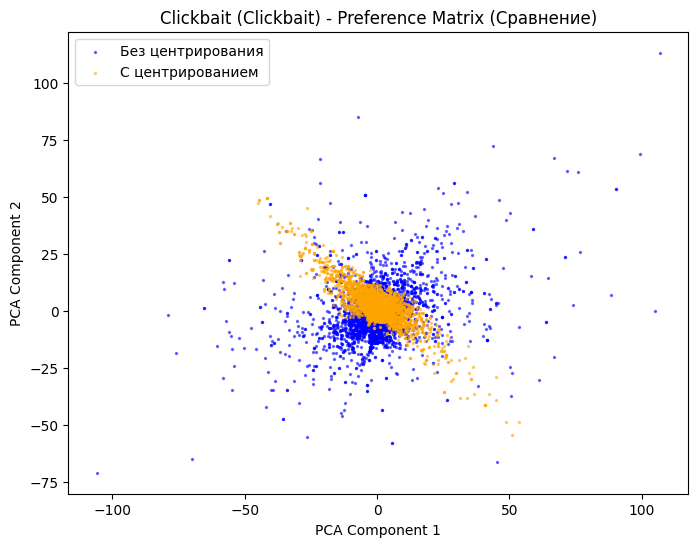

Визуализация для домена: sentiment
Сравнение для поддомена: sentiment


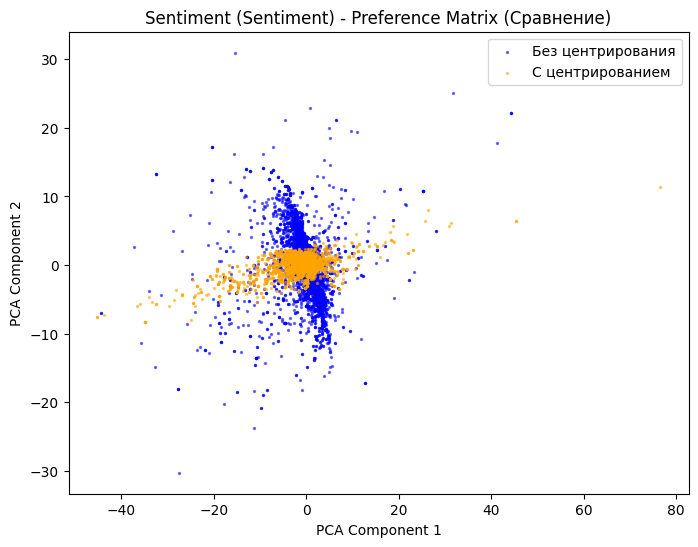

In [ ]:
results_dicts = {"toxicity": results_toxicity, "clickbait": results_clickbait, "sentiment": results_sentiment}

for domain, results in results_dicts.items():
    print(f"Визуализация для домена: {domain}")
    
    for subdomain, data in results.items():
        print(f"Сравнение для поддомена: {subdomain}")
        
        pca_visualize_pref_matrices(
            pref_matrix_1=data["not_center_pref_matrix"], 
            pref_matrix_2=data["center_pref_matrix"], 
            title=f"{subdomain.capitalize()} ({domain.capitalize()}) - Preference Matrix (Сравнение)",
            labels=("Без центрирования", "С центрированием")
        )


In [19]:
def compare_singular_values(pref_matrix, centered_matrix, title="Сравнение сингулярных значений"):
    """
    Сравнивает сингулярные значения матрицы предпочтений до и после центрирования.
    Args:
        pref_matrix (torch.Tensor): Матрица предпочтений до центрирования.
        centered_matrix (torch.Tensor): Матрица предпочтений после центрирования.
        title (str): Заголовок графика.
    """
    _, s_before, _ = torch.linalg.svd(pref_matrix.reshape(-1, pref_matrix.shape[-1]), full_matrices=False)
    _, s_after, _ = torch.linalg.svd(centered_matrix.reshape(-1, centered_matrix.shape[-1]), full_matrices=False)
    
    plt.figure(figsize=(8, 6))
    plt.plot(s_before.cpu().numpy(), label="До центрирования", marker='o', linestyle='-', color='blue')
    plt.plot(s_after.cpu().numpy(), label="После центрирования", marker='x', linestyle='--', color='orange')
    plt.title(title)
    plt.xlabel("Индекс сингулярного значения")
    plt.ylabel("Сингулярные значения")
    plt.legend()
    plt.grid()
    plt.show()

Сравнение сингулярных значений для домена: toxicity


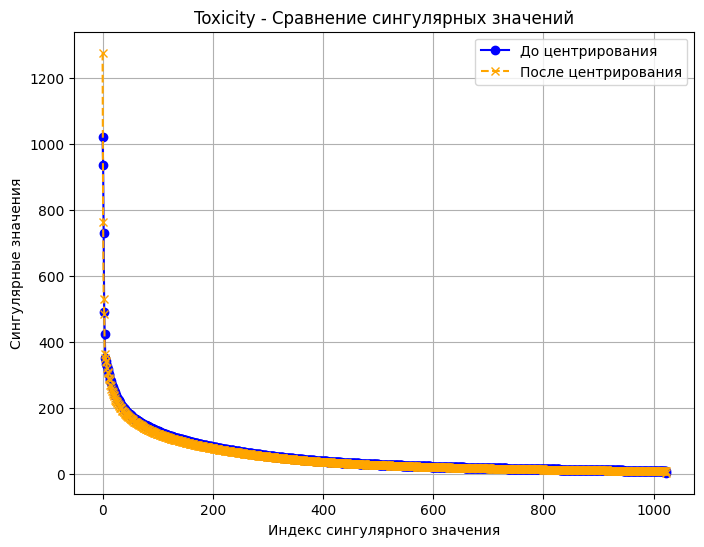

In [20]:
for domain, data in results_toxicity.items():
    print(f"Сравнение сингулярных значений для домена: {domain}")
    compare_singular_values(
        data["not_center_pref_matrix"], 
        data["center_pref_matrix"], 
        title=f"{domain.capitalize()} - Сравнение сингулярных значений"
    )


Сравнение сингулярных значений для домена: clickbait


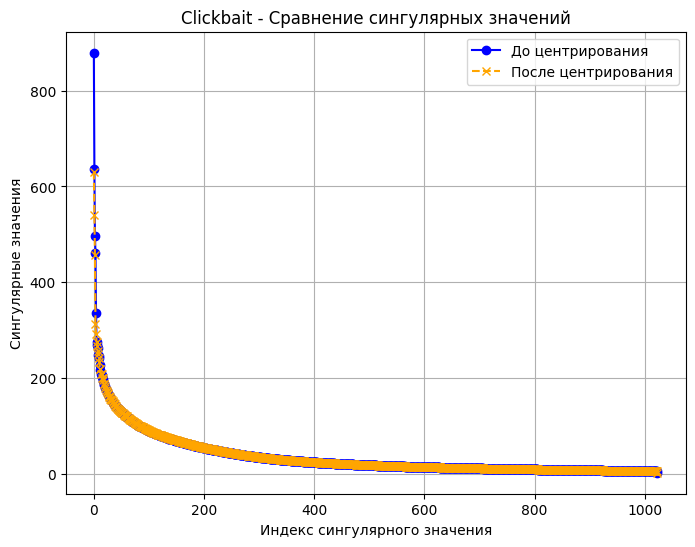

: 

In [ ]:
for domain, data in results_clickbait.items():
    print(f"Сравнение сингулярных значений для домена: {domain}")
    compare_singular_values(
        data["not_center_pref_matrix"], 
        data["center_pref_matrix"], 
        title=f"{domain.capitalize()} - Сравнение сингулярных значений"
    )


Сравнение сингулярных значений для домена: sentiment


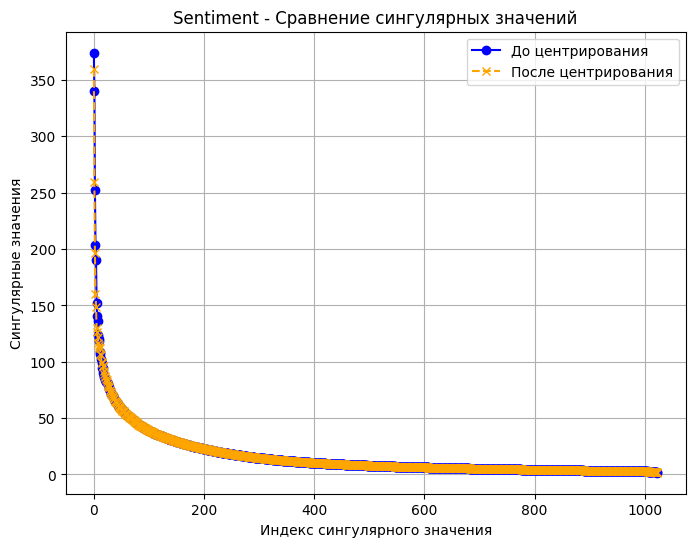

In [24]:
for domain, data in results_sentiment.items():
    print(f"Сравнение сингулярных значений для домена: {domain}")
    compare_singular_values(
        data["not_center_pref_matrix"], 
        data["center_pref_matrix"], 
        title=f"{domain.capitalize()} - Сравнение сингулярных значений"
    )

Визуализация для домена: toxicity
Сравнение для поддомена: toxicity


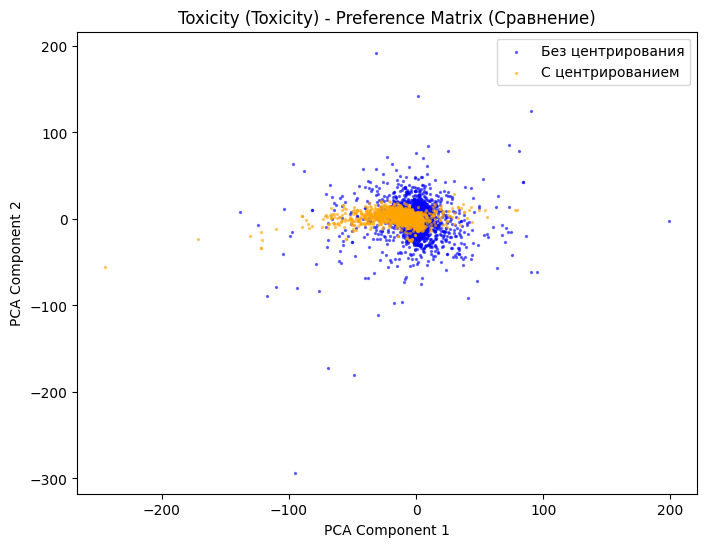

Визуализация для домена: clickbait
Сравнение для поддомена: clickbait


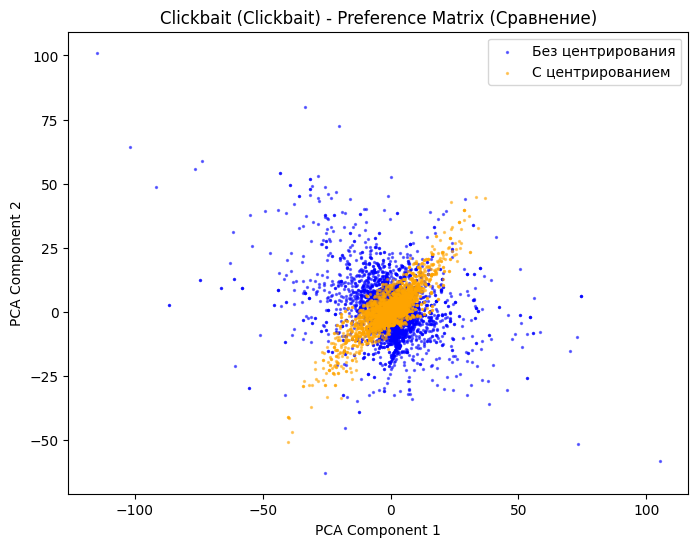

Визуализация для домена: sentiment
Сравнение для поддомена: sentiment


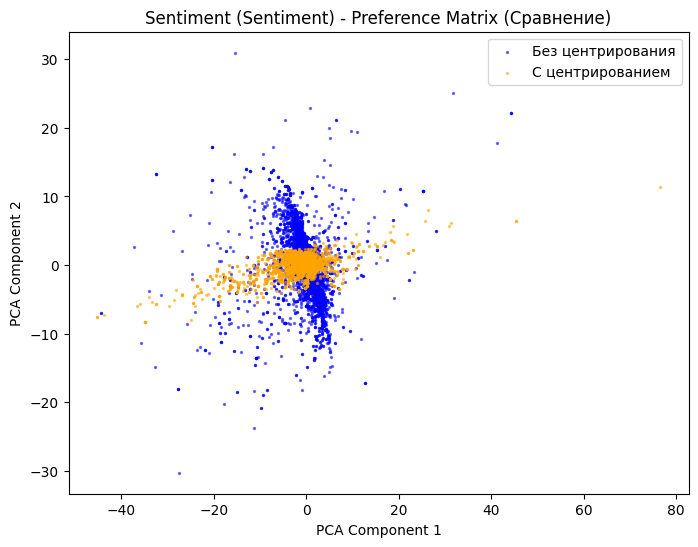

In [29]:
results_dicts = {"toxicity": results_toxicity, "clickbait": results_clickbait, "sentiment": results_sentiment}

for domain, results in results_dicts.items():
    print(f"Визуализация для домена: {domain}")
    
    for subdomain, data in results.items():
        print(f"Сравнение для поддомена: {subdomain}")
        
        pca_visualize_pref_matrices(
            pref_matrix_1=data["not_center_pref_matrix"], 
            pref_matrix_2=data["center_pref_matrix"], 
            title=f"{subdomain.capitalize()} ({domain.capitalize()}) - Preference Matrix (Сравнение)",
            labels=("Без центрирования", "С центрированием")
        )


In [11]:
def visualize_embeddings_pca(pre_embs, post_embs, title):
    """
    Визуализация эмбеддингов до и после проекции на ортогональное дополнение.
    Args:
        pre_embs (torch.Tensor): Эмбеддинги до проекции (L, N, D).
        post_embs (torch.Tensor): Эмбеддинги после проекции (L, N, D).
        title (str): Заголовок графика.
    """
    from sklearn.decomposition import PCA
    import matplotlib.pyplot as plt

    pre_embs = pre_embs.cpu().numpy().reshape(-1, pre_embs.shape[-1])
    post_embs = post_embs.cpu().numpy().reshape(-1, post_embs.shape[-1])
    
    combined_embs = np.vstack([pre_embs, post_embs])
    pca = PCA(n_components=2)
    reduced = pca.fit_transform(combined_embs)
    
    reduced_pre = reduced[:len(pre_embs)]
    reduced_post = reduced[len(pre_embs):]

    plt.figure(figsize=(8, 6))
    plt.scatter(reduced_pre[:, 0], reduced_pre[:, 1], s=5, alpha=0.5, label="До проекции", color="blue")
    plt.scatter(reduced_post[:, 0], reduced_post[:, 1], s=5, alpha=0.5, label="После проекции", color="orange")
    plt.title(title)
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.legend()
    plt.grid()
    plt.show()


Визуализация распределения эмбеддингов для домена: toxicity


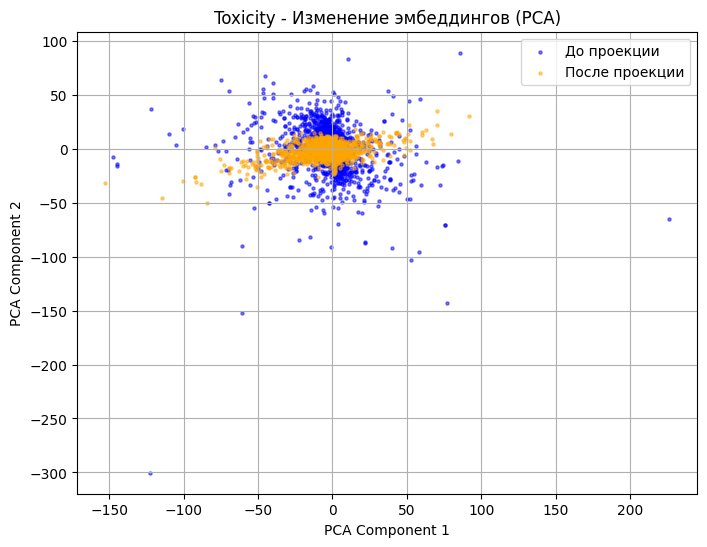

In [12]:
for domain, data in results_toxicity.items():
    print(f"Визуализация распределения эмбеддингов для домена: {domain}")
    
    not_center_pref_matrix = data["not_center_pref_matrix"]
    center_pref_matrix = data["center_pref_matrix"]
    
    visualize_embeddings_pca(
        pre_embs=not_center_pref_matrix, 
        post_embs=center_pref_matrix, 
        title=f"{domain.capitalize()} - Изменение эмбеддингов (PCA)"
    )


In [22]:
data_path = "toxicity_pairwise/toxicity.jsonl"

In [24]:
def visualize_pref_matrices_pca(pref_matrices, domains):
    """
    Визуализация матриц предпочтений для нескольких доменов с использованием PCA.
    Args:
        pref_matrices (dict): Словарь с матрицами предпочтений для каждого домена.
        domains (list): Список доменов.
    """
    from sklearn.decomposition import PCA
    plt.figure(figsize=(10, 7))
    
    for domain in domains:
        matrix = pref_matrices[domain].cpu().numpy().reshape(-1, pref_matrices[domain].shape[-1])
        pca = PCA(n_components=2)
        reduced = pca.fit_transform(matrix)
        plt.scatter(reduced[:, 0], reduced[:, 1], label=domain, alpha=0.6, s=10)

    plt.title("PCA проекции матриц предпочтений для разных доменов")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.legend()
    plt.show()


In [26]:
data_paths = {
    "toxicity": "toxicity_pairwise/toxicity.jsonl",
    "sentiment": "toxicity_pairwise/sentiment.jsonl",
    "clickbait": "toxicity_pairwise/clickbait.jsonl"
}

pref_matrices = {}

for domain, path in data_paths.items():
    print(f"Обрабатываем домен: {domain}")
    
    editor_center = DeToxEdit(
        model=model,
        tokenizer=tokenizer,
        pref_data_dps=300,
        centering=True,
        top_k_ranks=2,
        edit_layer_range=layer_range,
        random_dps=True
    )
    center_ats, center_pref_matrix = editor_center.get_ats(path)
    
    pref_matrices[domain] = center_pref_matrix



Обрабатываем домен: toxicity


INFO:root:Loaded 300 preferred and 300 non-preferred samples.
INFO:root:Batch 1/6 of size 50
INFO:root:Batch 2/6 of size 50
INFO:root:Batch 3/6 of size 50
INFO:root:Batch 4/6 of size 50
INFO:root:Batch 5/6 of size 50
INFO:root:Batch 6/6 of size 50
INFO:root:Hidden sent: torch.Size([24, 300, 1024])
INFO:root:Batch 1/6 of size 50
INFO:root:Batch 2/6 of size 50
INFO:root:Batch 3/6 of size 50
INFO:root:Batch 4/6 of size 50
INFO:root:Batch 5/6 of size 50
INFO:root:Batch 6/6 of size 50
INFO:root:Hidden sent: torch.Size([24, 300, 1024])
INFO:root:Preference matrix calculated.
INFO:root:Centering: Removing first singular vector from preference matrix.
INFO:root:Loaded 300 preferred and 300 non-preferred samples.


Обрабатываем домен: sentiment


INFO:root:Batch 1/6 of size 50
INFO:root:Batch 2/6 of size 50
INFO:root:Batch 3/6 of size 50
INFO:root:Batch 4/6 of size 50
INFO:root:Batch 5/6 of size 50
INFO:root:Batch 6/6 of size 50
INFO:root:Hidden sent: torch.Size([24, 300, 1024])
INFO:root:Batch 1/6 of size 50
INFO:root:Batch 2/6 of size 50
INFO:root:Batch 3/6 of size 50
INFO:root:Batch 4/6 of size 50
INFO:root:Batch 5/6 of size 50
INFO:root:Batch 6/6 of size 50
INFO:root:Hidden sent: torch.Size([24, 300, 1024])
INFO:root:Preference matrix calculated.
INFO:root:Centering: Removing first singular vector from preference matrix.
INFO:root:Loaded 300 preferred and 300 non-preferred samples.


Обрабатываем домен: clickbait


INFO:root:Batch 1/6 of size 50
INFO:root:Batch 2/6 of size 50
INFO:root:Batch 3/6 of size 50
INFO:root:Batch 4/6 of size 50
INFO:root:Batch 5/6 of size 50
INFO:root:Batch 6/6 of size 50
INFO:root:Hidden sent: torch.Size([24, 300, 1024])
INFO:root:Batch 1/6 of size 50
INFO:root:Batch 2/6 of size 50
INFO:root:Batch 3/6 of size 50
INFO:root:Batch 4/6 of size 50
INFO:root:Batch 5/6 of size 50
INFO:root:Batch 6/6 of size 50
INFO:root:Hidden sent: torch.Size([24, 300, 1024])
INFO:root:Preference matrix calculated.
INFO:root:Centering: Removing first singular vector from preference matrix.


In [27]:
import torch
torch.save(pref_matrices, "pref_matrices.pt")

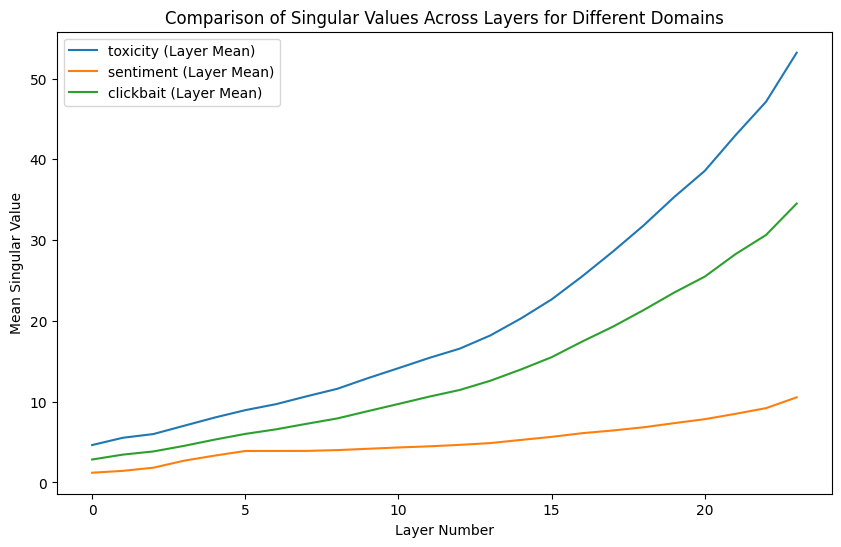

In [83]:
def compare_singular_values_per_layer(pref_matrices, domains):
    """
    Compares singular values for each layer across different domains.
    Args:
        pref_matrices (dict): Dictionary containing preference matrices for each domain.
        domains (list): List of domains.
    """
    import matplotlib.pyplot as plt
    import torch

    plt.figure(figsize=(10, 6))
    for domain in domains:
        matrix = pref_matrices[domain]  # (L, N, D)
        singular_values = []
        
        for layer in range(matrix.shape[0]):  
            _, s, _ = torch.linalg.svd(matrix[layer], full_matrices=False)
            singular_values.append(s.cpu().numpy().mean())
        
        plt.plot(singular_values, label=f"{domain} (Layer Mean)")
        
    plt.title("Comparison of Singular Values Across Layers for Different Domains")
    plt.xlabel("Layer Number")
    plt.ylabel("Mean Singular Value")
    plt.legend()
    plt.show()

compare_singular_values_per_layer(pref_matrices, domains=list(pref_matrices.keys()))


In [89]:
def compare_singular_values_per_layer(pref_matrices, domains):
    """
    Compares singular values for each layer across different domains.
    Args:
        pref_matrices (dict): Dictionary containing preference matrices for each domain.
        domains (list): List of domains.
    """
    import matplotlib.pyplot as plt
    import torch

    plt.figure(figsize=(12, 6))
    for domain in domains:
        if domain not in pref_matrices or pref_matrices[domain] is None:
            print(f"Warning: No data found for domain '{domain}'")
            continue
        
        matrix = pref_matrices[domain]
        if len(matrix.shape) != 3:
            print(f"Error: Matrix for domain '{domain}' does not have shape (L, N, D). Actual shape: {matrix.shape}")
            continue
        
        mean_singular_values = []
        for layer in range(matrix.shape[0]):  
            _, s, _ = torch.linalg.svd(matrix[layer], full_matrices=False)
            s = s.cpu().numpy()
            mean_singular_values.append(s.mean())
            print(f"Domain: {domain}, Layer {layer}, Mean Singular Value: {s.mean()}")  # Debug output
        
        if mean_singular_values:
            plt.plot(mean_singular_values, label=f"{domain} (Layer Mean)")

    plt.title("Comparison of Mean Singular Values Across Layers for Different Domains")
    plt.xlabel("Layer Number")
    plt.ylabel("Mean Singular Value")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()


Domain: toxicity, Layer 0, Mean Singular Value: 4.627054691314697
Domain: toxicity, Layer 1, Mean Singular Value: 5.526573657989502
Domain: toxicity, Layer 2, Mean Singular Value: 5.989843368530273
Domain: toxicity, Layer 3, Mean Singular Value: 7.013243675231934
Domain: toxicity, Layer 4, Mean Singular Value: 8.031351089477539
Domain: toxicity, Layer 5, Mean Singular Value: 8.94822883605957
Domain: toxicity, Layer 6, Mean Singular Value: 9.687065124511719
Domain: toxicity, Layer 7, Mean Singular Value: 10.658870697021484
Domain: toxicity, Layer 8, Mean Singular Value: 11.588343620300293
Domain: toxicity, Layer 9, Mean Singular Value: 12.9058256149292
Domain: toxicity, Layer 10, Mean Singular Value: 14.146703720092773
Domain: toxicity, Layer 11, Mean Singular Value: 15.410879135131836
Domain: toxicity, Layer 12, Mean Singular Value: 16.562408447265625
Domain: toxicity, Layer 13, Mean Singular Value: 18.19732093811035
Domain: toxicity, Layer 14, Mean Singular Value: 20.303434371948242
D

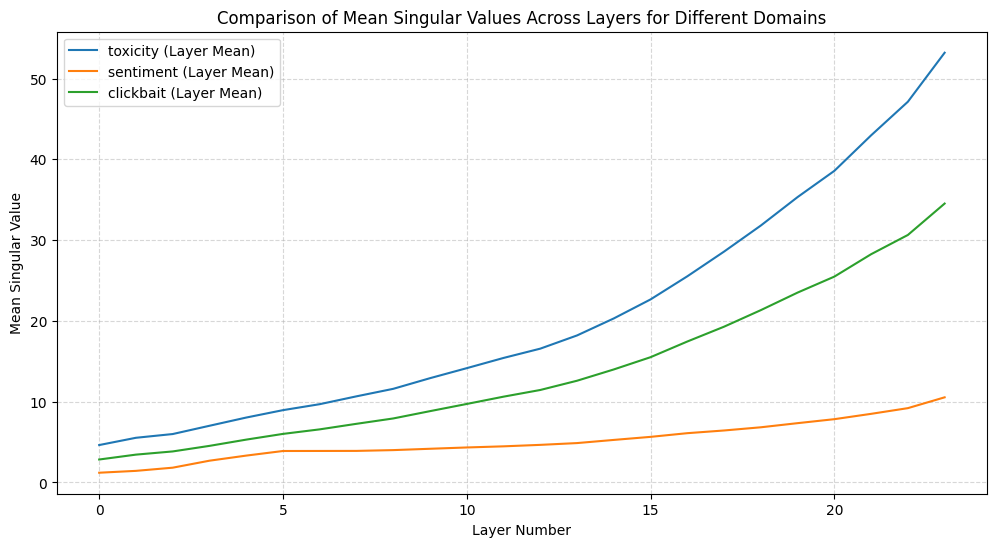

In [90]:
compare_singular_values_per_layer(pref_matrices, domains=list(pref_matrices.keys()))

In [81]:
def visualize_pref_matrices_pca(pref_matrices, domains):
    """
    Visualization of preference matrices for multiple domains using PCA.
    Args:
        pref_matrices (dict): Dictionary containing preference matrices for each domain.
        domains (list): List of domains.
    """
    from sklearn.decomposition import PCA
    import matplotlib.pyplot as plt
    import numpy as np
    
    plt.figure(figsize=(12, 8))
    
    for domain in domains:

        matrix = pref_matrices[domain].cpu().numpy().reshape(-1, pref_matrices[domain].shape[-1])
        

        pca = PCA(n_components=10)
        reduced = pca.fit_transform(matrix)
        
        explained_variance = pca.explained_variance_ratio_
        cumulative_variance = np.cumsum(explained_variance)
        print(f"Domain: {domain}, Explained variance by the first two components: {explained_variance[:2].sum():.2%}")
        print(f"Domain: {domain}, Cumulative explained variance (10 components): {cumulative_variance[-1]:.2%}")
        
        plt.scatter(
            reduced[:, 0], reduced[:, 1], 
            label=f"{domain} (Explained: {explained_variance[:2].sum():.2%})", 
            alpha=0.6, s=10
        )

    plt.title("PCA Projections of Preference Matrices for Different Domains")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.legend(loc='best')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()


Domain: toxicity, Explained variance by the first two components: 19.85%
Domain: toxicity, Cumulative explained variance (10 components): 34.88%
Domain: sentiment, Explained variance by the first two components: 18.43%
Domain: sentiment, Cumulative explained variance (10 components): 37.07%
Domain: clickbait, Explained variance by the first two components: 15.77%
Domain: clickbait, Cumulative explained variance (10 components): 33.86%


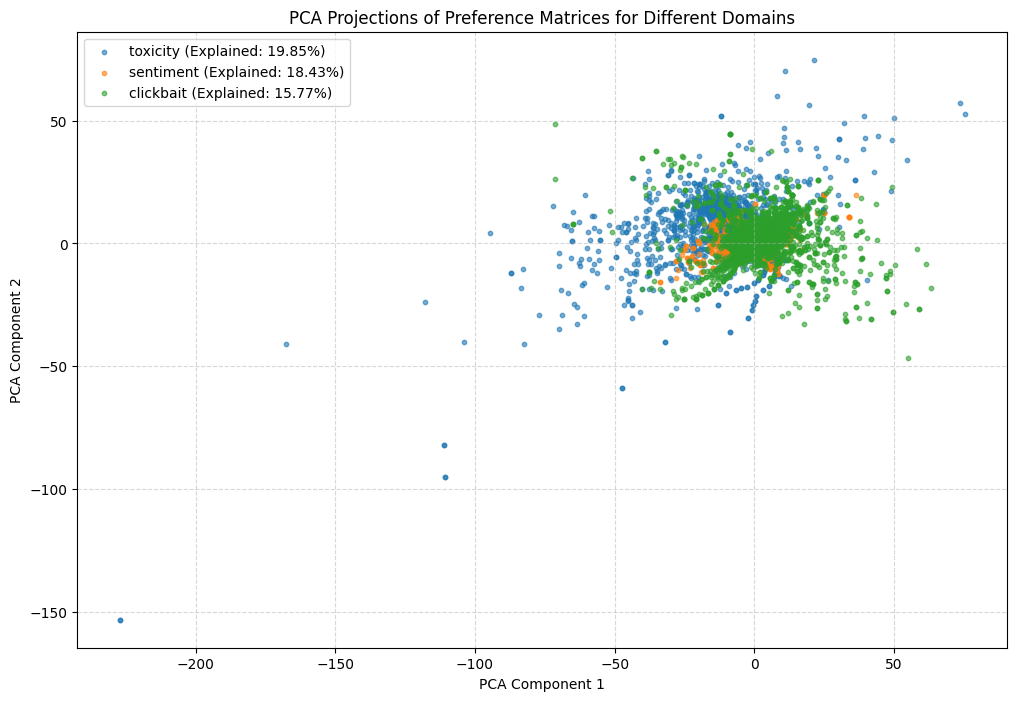

In [82]:
visualize_pref_matrices_pca(pref_matrices, domains=list(pref_matrices.keys()))

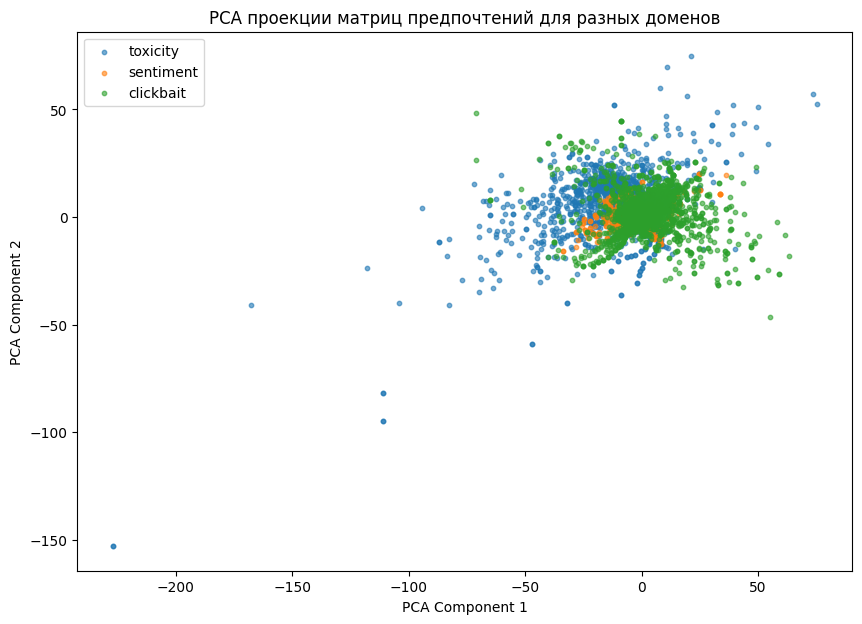

In [36]:
visualize_pref_matrices_pca(pref_matrices, domains=list(pref_matrices.keys()))

In [37]:
def compare_cosine_similarity(pref_matrices, domains):
    """
    Сравнивает косинусное сходство между матрицами предпочтений разных доменов.
    Args:
        pref_matrices (dict): Словарь с матрицами предпочтений для каждого домена.
        domains (list): Список доменов.
    """
    from sklearn.metrics.pairwise import cosine_similarity
    similarities = {}
    
    for i, domain1 in enumerate(domains):
        for j, domain2 in enumerate(domains):
            if i < j:
                mat1 = pref_matrices[domain1].cpu().numpy().reshape(-1, pref_matrices[domain1].shape[-1])
                mat2 = pref_matrices[domain2].cpu().numpy().reshape(-1, pref_matrices[domain2].shape[-1])
                sim = cosine_similarity(mat1, mat2).mean()
                similarities[f"{domain1}-{domain2}"] = sim
    
    for pair, sim in similarities.items():
        print(f"Сходство между {pair}: {sim:.4f}")

In [38]:
compare_cosine_similarity(pref_matrices, domains=list(pref_matrices.keys()))

Сходство между toxicity-sentiment: 0.0161
Сходство между toxicity-clickbait: 0.0479
Сходство между sentiment-clickbait: 0.0077
